# Assignment 4: Modeling Epidemics

In [192]:
import time

import EoN as eon
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import networkx as nx
import numpy as np
import scipy
import random
from collections import defaultdict
from tqdm.notebook import tqdm
from scipy.optimize import curve_fit

## Part 1: Outbreak Modeling [40 Points]

In [193]:
def load_flu_network():
#     # Read the graph
#     G = nx.read_edgelist("fludata.txt", nodetype=int, data=(("weight", float),))
    
    # Create an empty undirected graph
    G = nx.Graph()
    
    # Read the file and add edges
    with open("fludata.txt", "r") as file:
        for line in file:
            # Split the line into columns
            columns = line.strip().split()
            
            if len(columns) >= 2:
                # Convert IDs to integers
                id1 = int(columns[0])
                id2 = int(columns[1])
                
                # Add the edge (without weight)
                G.add_edge(id1, id2)
    
    return G

### 1.1

In [194]:
def simulate_outbreak(G, n_iter, initial_infected=325, tmax=10, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        n_iter : int
              Number of simulations to run.
        initial_infected : int
                        The node that is initially infected
        tmax : int
        beta : float
        mu : float

    Returns:
        simulation_runs : list[tuple] -
                       This is a list like object of tuples of the
                       form (t, S, I). Each tuple (t, S, I) represents
                       a simulated run, where t, S, I are vectors representing
                       the time periods, and the corresponding numbers of susceptible
                       and infected people.
    """
    simulation_runs = []
    
    non_dead_simulations = 0
    
    while non_dead_simulations < n_iter:
        
        # Set up the time steps from 0 to 10
        time_intervals = [t for t in range(tmax + 1)]
        
        # Initialize infected and susceptible and record num of infected & susceptible for each time stamp
        # We assume the outbreak start at node 325
        infected = set([initial_infected])
        infect_list = [len(infected)]
        susceptible = set(G.nodes()).difference(infected)
        suscept_list = [len(susceptible)]
        
        # Run the simulation with tmax times
        for t in range(1, tmax + 1):
            # Recover process with recovery rate = 0.5
            recoveries = set()
            for node in infected:
                if mu > random.random(): 
                    recoveries.add(node)
            
            # Infection Process with transmission rate = 0.01
            infections = set()
            for node in susceptible:
                # Check neighbors that were already infected
                neigh_infections = {neigh for neigh in G.neighbors(node) if neigh in infected}
                # Calculate the infection probability
                infect_probability = 1 - (1 - beta) ** len(neigh_infections)
                if infect_probability > random.random():
                    infections.add(node)
            
            # Update the infected and susceptible list at the current time stamp and record it.
            infected = infected.difference(recoveries).union(infections)
            infect_list.append(len(infected))
            susceptible = susceptible.difference(infections).union(recoveries)
            suscept_list.append(len(susceptible))
        
        # If the simulation is not dead (number of infected nodes is not 0 at the last step), 
        # it is a valid simulation
        if infect_list[-1] > 0:
            non_dead_simulations += 1
            simulation_runs.append((time_intervals, suscept_list, infect_list))
    
    return simulation_runs


def plot_outbreaks(simulation_runs, save=False):
    """
    Inputs:
        simulation_runs : list[tuple]
                      The list like object of tuples returned by `simulate_outbreak`.
        save : bool
           Whether to save the figure.
    """
    
    plt.figure(figsize=(12, 8))
    
    # Create the color cycle to represent different simulations
    from itertools import cycle
    color_cycle = cycle(plt.cm.tab10.colors)
    
    # Clear any existing legend entries
    plt.gca().get_legend().remove() if plt.gca().get_legend() else None
    
    # Plot each simulation and add it to the legend list
    legend_elements = []
    for i, (t, S, I) in enumerate(simulation_runs):
        color = next(color_cycle)
        sim_name = f"Simulation {i+1}"
        
        # Plot the susceptible line
        plt.plot(t, S, color=color, linestyle='-', label=f'{sim_name}: Susceptible', alpha=0.6)
        legend_elements.append(Line2D([0], [0], color=color, linestyle='-', label=f"{sim_name}: Susceptible"))
        
        # Plot the infected line
        plt.plot(t, I, color=color, linestyle='--', label=f'{sim_name}: Infected', alpha=0.6)
        legend_elements.append(Line2D([0], [0], color=color, linestyle='--', label=f"{sim_name}: Infected"))

    # Create legend
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))

     # Add labels and title
    plt.xlabel('Time Stamp')
    plt.ylabel('Number of people')
    plt.title('Model for SIS Epidemic')
    
    plt.tight_layout()
    
    if save:
        plt.savefig("1_1.png")
    plt.show()

### 1.2

In [195]:
def get_exponent(simulation_run, I_thrsh=100):
    """
    Inputs:
        simulation_run : tuple
                      A tuple of (t, S, I) as specified in `simulate_outbreak()`
        I_thrsh : int
               Threshold of I. We only fit the curve where I<=I_thrsh

    Returns:
        tau : float
    """
    
    timeStamp, susceptible, infected = simulation_run
    
    t = np.array(timeStamp)
    I = np.array(infected)
    
    # Filter infected data and we only want to include points where I <= I_thrsh
    filtered_infected = []
    filtered_time = []
    for i in range(len(t)):
        if I[i] <= I_thrsh:
            filtered_infected.append(I[i])
            filtered_time.append(t[i])
    filtered_time = np.array(filtered_time)
    filtered_infected = np.array(filtered_infected)
    
    # Fix the exponent to a curve and extract fitted parameters 
    # Set up the initial value to [1.0]
    popt, _ = curve_fit(lambda t, tau: np.exp(t / tau), filtered_time, filtered_infected, p0=[1])
    tau = popt[0]
    
    return tau
    

def plot_curve_fit(simulation_run, tau, I_thrsh=100, save=False):
    """
    Inputs:
        simulation_run : tuple
        I_thrsh : int
        tau : float
        save : bool
    """
    timeStamp, susceptible, infected = simulation_run
    
    t = np.array(timeStamp)
    I = np.array(infected)
    
    # Filter infected data and we only want to include points where I <= I_thrsh
    filtered_infected = []
    filtered_time = []
    for i in range(len(t)):
        if I[i] <= I_thrsh:
            filtered_infected.append(I[i])
            filtered_time.append(t[i])
    filtered_time = np.array(filtered_time)
    filtered_infected = np.array(filtered_infected)
    
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Generate the theoretical curve using the fitted tau
    # I(t) = I_0 * e^(t/tau), where I_0 = 1
    infected_theoretical = 1 * np.exp(filtered_time / tau)
    plt.plot(filtered_time, infected_theoretical, 'r-', label='Theoretical Fit')
    
    # Draw the actual data points
    plt.scatter(filtered_time, filtered_infected, color='blue', label='Simulation Data')
    
    # Calculate R-squared (R^2 = 1 - SS_res / SS_tot) 
    infected_mean = np.mean(filtered_infected)
    ss_tot = np.sum((filtered_infected - infected_mean)**2)
    res = filtered_infected - infected_theoretical
    ss_res = np.sum(res**2)
    if ss_tot == 0:
        r2 = 0
    else:
        r2 = 1 - (ss_res / ss_tot)
    
    # Add axis labels and title with tau and R^2 values
    plt.title(f'Exponential Growth Fit: τ = {tau:.4f}, R² = {r2:.4f}')
    plt.xlabel('Time Stamp')
    plt.ylabel('Infected People')
    
    # Add grid and legend
    plt.legend()
    
    # Set y-axis to log scale to better visualize exponential growth
    plt.yscale('log')


    if save:
        plt.savefig("1_2.png")

    plt.show()
    return r2

### 1.3

In [196]:
def calculate_theoretical_taus(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        tau_rand : float
        tau_slide : float
        tau_book : float
    """
    
    # Get the total number of nodes
    population = G.number_of_nodes()
    
    # Get the average degree of these nodes
    average_degree = 2 * G.number_of_edges() / population
    
    # Calculate second moment of degree distribution <k²>
    total_degree = 0
    for _, deg in G.degree():
        total_degree += deg**2
    second_moment = total_degree / population
    
    # Calculate spreading rate λ = β/μ
    lambda_val = beta / mu
    
    # 1. τ = <k> / (β<k> - μ)
    tau_rand = average_degree / (beta * average_degree - mu)
    
    # 2. τ = <k> / (β<k²> - (β+μ)<k>)
    tau_slide = average_degree / (beta * second_moment - (beta + mu) * average_degree)
    
    # 3. τ = <k> / (β<k²> - μ<k>)
    tau_book = average_degree / (beta * second_moment - mu * average_degree)
    
    return tau_rand, tau_slide, tau_book


def compare_taus(empirical_taus, tau_rand, tau_slide, tau_book, save=False):
    """
    This function visually compares the empirical_taus, tau_rand, tau_slide,
    and tau_book on a boxplot.

    Inputs:
        empirical_taus : list[float]
                      List-like object of floats containing the list of tau's
        tau_rand : float
        tau_slide : float
        tau_book : float
        save : bool
    """
    
    # Create a figure
    plt.figure(figsize=(12, 7))
    
    # Create a boxplot of the empirical taus
    plt.boxplot(empirical_taus, patch_artist=True)
    
    # Add the theoretical tau values as colored dots
    x_pos = 1  # Position of the boxplot
    
    # Add tau random, tau slide, tau book points to the plot
    plt.plot(x_pos, tau_rand, 'go', label='tau_rand', markersize=6,)
    plt.plot(x_pos, tau_slide, 'bo', label='tau_slide', markersize=6)
    plt.plot(x_pos, tau_book, 'ro', label='tau_book', markersize=6)
    
    # Calculate statistics for the empirical taus
    emp_mean = np.mean(empirical_taus)
    emp_std = np.std(empirical_taus)
    
    # Add labels and title
    plt.title(f"""Comparison of Theoretical and Empirical Characteristic Times
Empirical Mean: {emp_mean:.3f} ± {emp_std:.3f}""", fontsize=10)
    plt.xlabel('SIS Model Simulation Results', fontsize=10)
    plt.ylabel('Characteristic Time Constant (τ)', fontsize=10)
    
    # Add a legend
    plt.legend(loc='best', fontsize=10)
    
    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Make room for the formula text box

    if save:
        plt.savefig("1_3.png")

    plt.show()

### 1.4

In [197]:
def calculate_theoretical_endemic_size(G, beta=0.01, mu=0.5):
    """
    Inputs:
        G : nx.Graph
        beta : float
        mu : float

    Returns:
        theoretical_endemic_size : int
    """
    
    # Get network size
    population = G.number_of_nodes()
    
    # Get the average degree of the network
    average_degree = sum(degree for _, degree in G.degree()) / population
    
    # Get the reproduction number R_0
    R_0 = average_degree * beta / mu
    
    # The endemic size = N * (1 - 1/R0).
    # If R0 <= 1, the epidemic dead.
    if R_0 > 1:
        theoretical_endemic_size = population * (1 - 1/R_0)
    else:
        theoretical_endemic_size = 0.0
    
    return theoretical_endemic_size


def compare_endemic_sizes(
    empirical_endemic_sizes, theoretical_endemic_size, save=False
):
    """
    Inputs:
        empirical_endemic_sizes : list[int]
                               List-like object of int's representing a distribution of
                               empirical endemic sizes from multiple simulation runs.
                               Refer to cell 1.5 to see how it works.
        theoretical_endemiz_size : int
        save : bool
    """
    # Create a figure
    plt.figure(figsize=(10, 6))
    
    # Create the boxplot for empirical_endemic_sizes
    plt.boxplot(empirical_endemic_sizes, patch_artist=True)
    
    # Add the theoretical endemic size point
    plt.plot(1, theoretical_endemic_size, 'bo', label='Theoretical Endemic Size', markersize=6)
    
    # Calculate statistics for labeling
    empirical_mean = np.mean(empirical_endemic_sizes)
    empirical_std = np.std(empirical_endemic_sizes)
    
    # Add labels and title
    plt.title(f"""Comparison of Endemic Size: Empirical vs Theoretical
Theoretical: {theoretical_endemic_size:.1f}, Empirical: {empirical_mean:.1f} ± {empirical_std:.1f}""")
    plt.xlabel('Simulation Results')
    plt.ylabel('Number of Infected Nodes at Endemic State')
    
    # Add a legend
    plt.legend(loc='upper right')
    
    # Add a grid
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Remove x-axis tick labels
    plt.xticks([])
    
    # Add a text annotation comparing the theoretical and empirical results
    difference = ((empirical_mean - theoretical_endemic_size) / theoretical_endemic_size * 100 
                  if theoretical_endemic_size > 0 else 0)
    
    text = "\n".join([
    f"Theoretical Endemic Size: {theoretical_endemic_size:.3f}",
    f"Empirical Mean: {empirical_mean:.3f}",
    f"Difference: {difference:.3f}%"
    ])
    
    plt.annotate(text, xy=(0.02, 0.02))
    
    # Adjust layout
    plt.tight_layout()

    if save:
        plt.savefig("1_4.png")

    plt.show()

### 1.5

>>>>> Results for Part 1 <<<<<


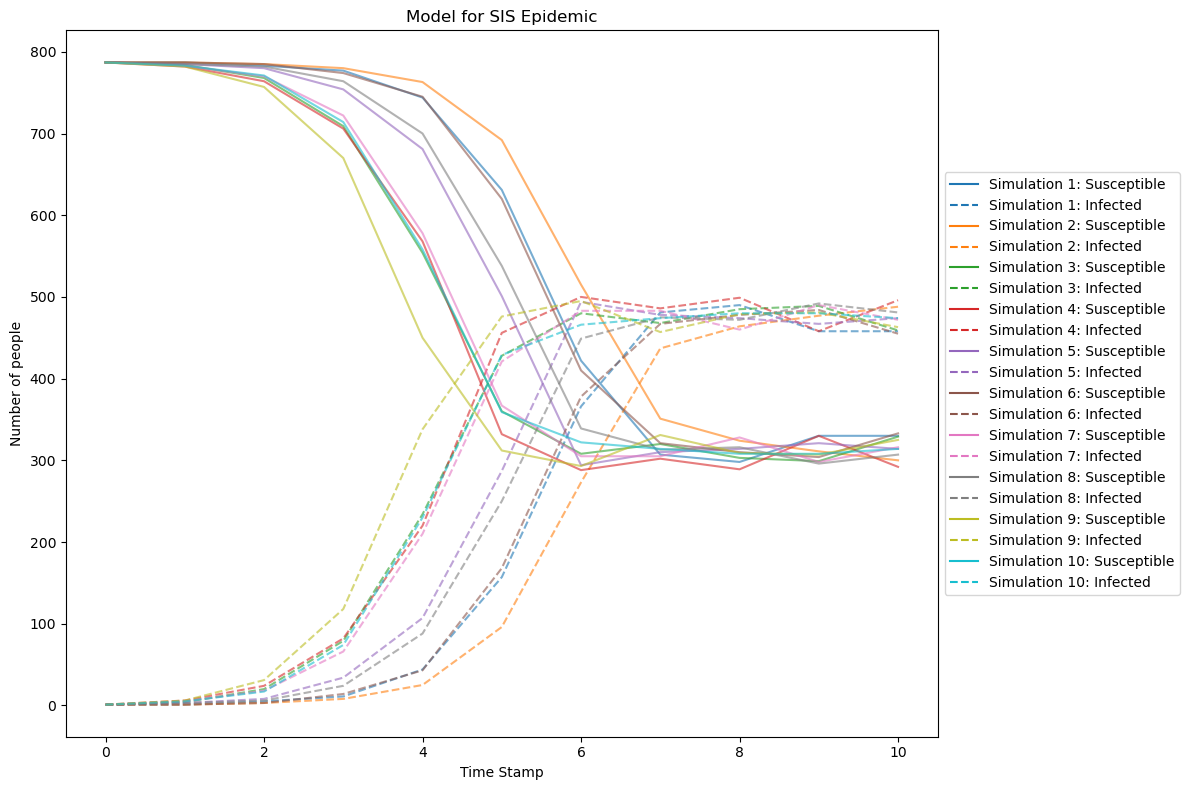

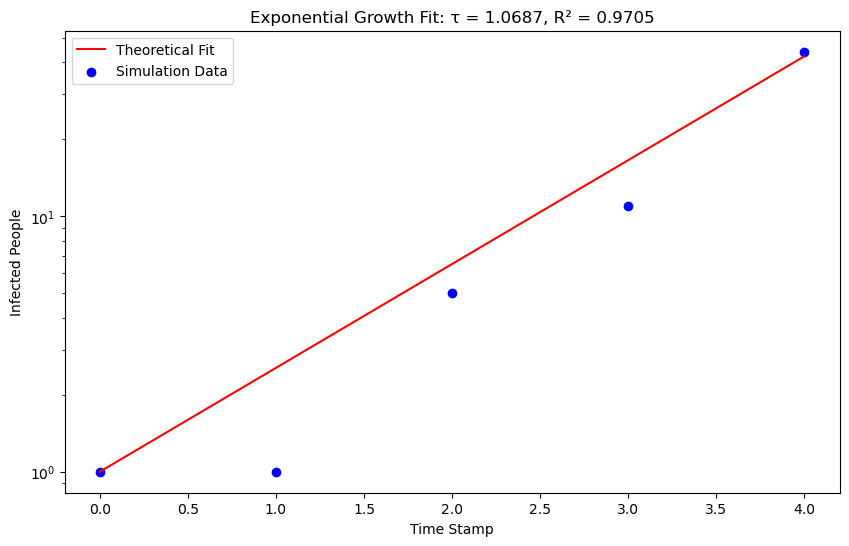

> Part 1.2 <
tau=1.07, R2=0.9705

> Part 1.3 <
tau_rand=119.9815, tau_slide=0.3512, tau_book=0.3499
Empirical distribution of tau
Count=25	Mean=0.819	std=0.134
Min=0.571	25%=0.721	50%=0.813	75%=0.882	Max=1.173


/var/folders/36/8zqvjhqn3pv281dfpc0qykr80000gn/T/ipykernel_20763/3219366017.py:30: RuntimeWarning: overflow encountered in exp
  popt, _ = curve_fit(lambda t, tau: np.exp(t / tau), filtered_time, filtered_infected, p0=[1])


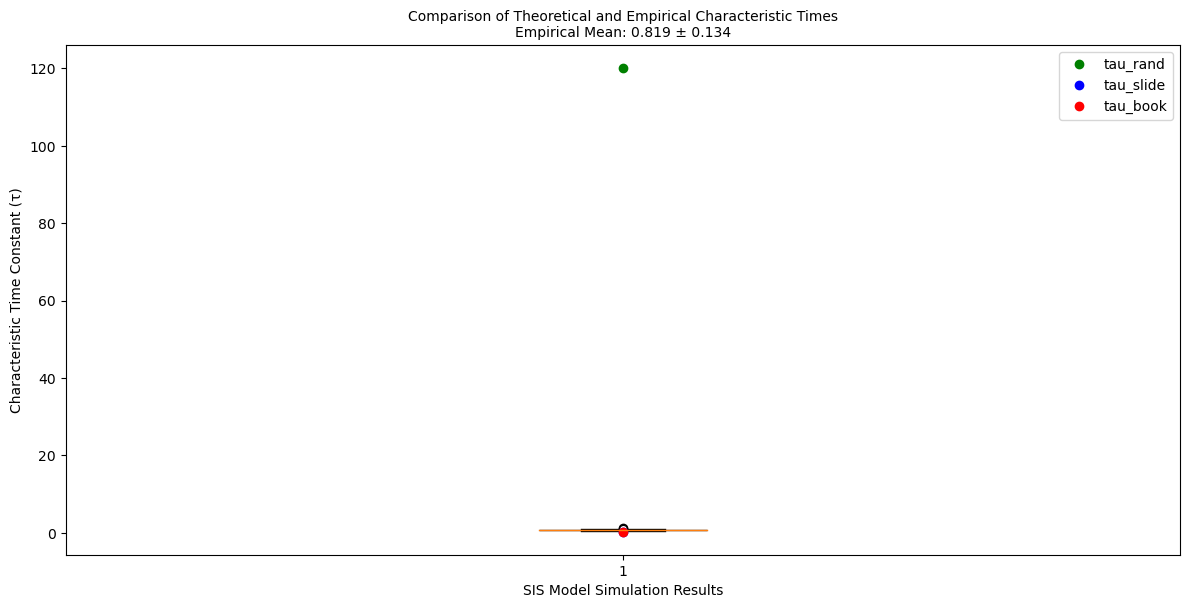


> Part 1.4 <


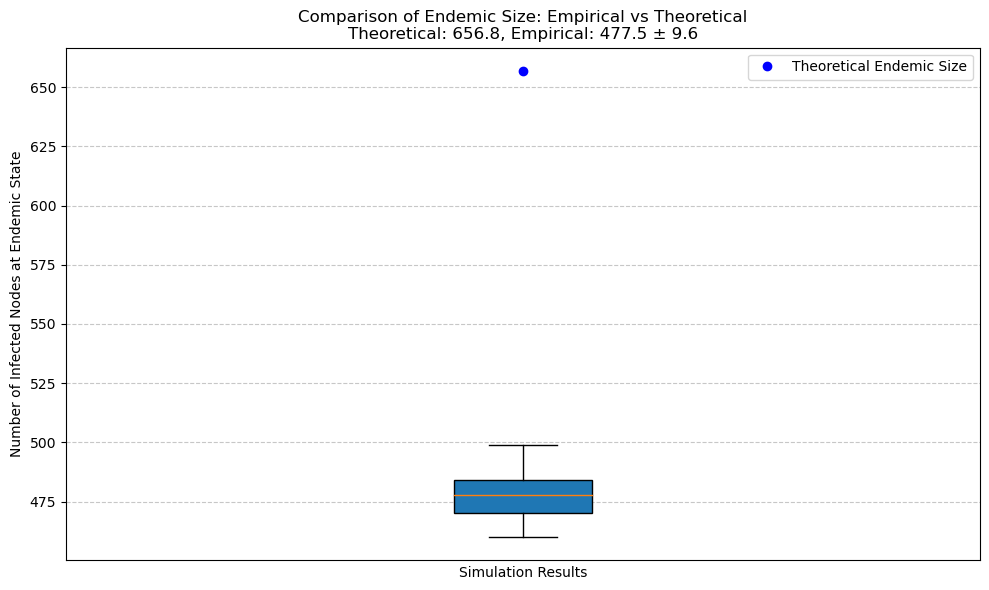

Theoretical endemic size=656.77
Empirical distribution of simulated endemic size
Count=25	Mean=477.480	std=9.625
Min=460.000	25%=470.000	50%=478.000	75%=484.000	Max=499.000


In [198]:
# Do not modify
print(">>>>> Results for Part 1 <<<<<")


G = load_flu_network()

# Generate 10 simulation runs for plotting
simulation_runs = simulate_outbreak(G, 10)

plot_outbreaks(simulation_runs)

tau = get_exponent(simulation_runs[0])
r2 = plot_curve_fit(simulation_runs[0], tau)
print("> Part 1.2 <")
print(f"tau={tau:.2f}, R2={r2:.4f}")

simulation_runs = simulate_outbreak(G, 25)

empirical_taus = []
empirical_endemic_sizes = []
for run in simulation_runs:
    empirical_taus.append(get_exponent(run))
    empirical_endemic_sizes.append(run[2][-1])

tau_rand, tau_slide, tau_book = calculate_theoretical_taus(G)
print("\n> Part 1.3 <")
print(f"tau_rand={tau_rand:.4f}, tau_slide={tau_slide:.4f}, tau_book={tau_book:.4f}")

print("Empirical distribution of tau")
def describe(x):
    print(
        "Count={count}\tMean={mean:.3f}\tstd={median:.3f}\n"
        "Min={min:.3f}\t25%={p25:.3f}\t50%={p50:.3f}\t75%={p75:<.3f}\tMax={max:.3f}".format(
            count=len(x),
            mean=np.mean(x),
            median=np.std(x),
            min=min(x),
            p25=np.percentile(x, 25),
            p50=np.median(x),
            p75=np.percentile(x, 75),
            max=max(x),
        )
    )
describe(empirical_taus)

compare_taus(empirical_taus, tau_rand, tau_slide, tau_book)

print("\n> Part 1.4 <")
theoretical_endemic_size = calculate_theoretical_endemic_size(G)

compare_endemic_sizes(empirical_endemic_sizes, theoretical_endemic_size)
print(f"Theoretical endemic size={theoretical_endemic_size:.2f}")
print("Empirical distribution of simulated endemic size")
describe(empirical_endemic_sizes)

### 1.5 Written Response

Answer: 

## Part 2: Transmission Rate Variation  $\beta$ [25 Points]

### 2.1 Minimum Transmission Rate for Epidemic

In [199]:
def simulate_beta_sweep(
    G,
    n_sims,
    beta_min=0.001,
    beta_max=0.04,
    beta_samples=40,
    initial_infected=325,
    tmax=10,
    mu=0.5,
):
    """
    Generate a list of betas. Run multiple simulations for each beta.
    Save the results.

    Inputs:
        G : nx.Graph
        n_sims : int
              Number of simulations (or runs) for each beta value
        beta_min : float
                Minimum beta to simulate
        beta_max : float
                Maximum beta to simulate
        beta_samples : int
                    The number of betas to simulate. That is, the function will
                    generate `beta_samples` betas between `beta_min` and `beta_max`.
        initial_infect : int
                      Initial infected node
        tmax : int
        mu : float

    Returns:
        betas : list[float]
             The list of betas the function has generated.
        beta_runs : list[list[tuple]]
                 Simulation results corresponding to `betas`. It is a list where
                 each itemis a list of tuples, representing multiple simulations
                 for a particular beta. The tuple is in the form of (t, S, I) as
                 in `simulate_outbreak` in Part 1.
    """
    
    num_samples = beta_samples
    betas = np.linspace(beta_min, beta_max, num_samples)
    beta_runs = []
    
    for beta in tqdm(betas):
        # For each beta, simulate n_sims times and store the first result from each
        simulations = []
        for i in range(n_sims):
            num_iteration = 1
            simulation = simulate_outbreak(G, num_iteration, initial_infected, tmax, beta, mu)[0]
            simulations.append(simulation)
        beta_runs.append(simulations)

    return betas, beta_runs


def extract_average_tau(beta_runs):
    """
    Estimate the average tau value for each beta value.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep` above.

    Returns:
        avg_taus : list[float]
                A list like object, where each item is the estimated
                average tau values of the corresponding simulations in
                `beta_runs` for a particular beta.
    """
    avg_taus = []

    for simulations in beta_runs:
        taus = []
        for simulation in simulations:
            taus.append(get_exponent(simulation))

        # Calculate the mean value of tau
        avg_tau = np.mean(taus)
        avg_taus.append(avg_tau)

    return avg_taus


def plot_beta_tau_curves(betas, avg_taus, t, save=False):
    """
    Inputs:
        betas : list[float]
        avg_taus : list[float]
        t : list[float]
        save: bool
    """
    
    plt.figure(figsize=(10, 6))
    
    # Create a colormap for different beta values
    # Create the color cycle to represent different simulations
    from itertools import cycle
    color_cycle = cycle(plt.cm.tab10.colors)
    
    # Plot exponential growth curves for each beta value
    for _, (beta, tau) in enumerate(zip(betas, avg_taus)):
        
        color = next(color_cycle)
        # Calculate the exponential curve: I(t) = I₀ * exp(τ*t)
        I_0 = 1  # Starting with one infected
        curve_func = I_0 * np.exp(tau * np.array(t))
        
        # Plot the curve with a distinct color
        plt.semilogy(t, curve_func, label=f'τ={tau:.3f}, β={beta:.3f}', color=color)
    
    plt.xlabel('Time')
    plt.ylabel('Number of infected (log scale)')
    plt.title('Exponential curves for each beta values')
    
    plt.legend(loc='best', fontsize=10)
    
    plt.tight_layout()

    if save:
        plt.savefig("2_1.png")

    plt.show()

### 2.2

In [218]:
def extract_average_endemic_size(beta_runs):
    """
    Given the simulated data, compute the average size of the endemic state for
    each beta value using the simulation data in `beta_runs`.

    Inputs:
        beta_runs : list[list[tuple]]
                 See docstring of `simulate_beta_sweep()` above.

    Returns:
        avg_ends : list[float]
                A list-like object of floats. Each item is the average endemic size
                for a particular beta value estimated using the corresponding simulation
                results in `beta_runs`.
    """
    avg_endemic_sizes = []

    for simulations in beta_runs:
        
        endemic_sizes = []
        
        for simulation in simulations:
            endemic_sizes.append(simulation[2][-1])
        
        # Compute the mean value for endemic size
        endemic_size_average = np.mean(endemic_sizes)
        
        # Compute mean endemic size over simulations for this beta
        avg_endemic_sizes.append(endemic_size_average)

    return avg_endemic_sizes


def calculate_theoretical_endemic(G, betas, mu=0.5):
    """
    Compute the theoretical endemic size for each beta value in `betas`,
    assuming random distribution.

    Additionally, compute the minimum theoretical beta for
    epdemic to occur, assuming random distribution and
    arbitrary distribution respectively.

    Inputs:
        G : nx.Graph
        betas : list[float]
             List of betas used to compute `theoretical_endemics`.
             Each item of the returned `theoretical_endemics` corresponds
             to a beta value in the `betas` list at the same index.
        mu : float

    Returns:
        theoretical_endemics : list[float]
                            A list-like object of theoretical endemic sizes
                            corresponding to the betas in the `betas` parameter.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
    """

    theoretical_endemic_sizes = []
    rand_dist_min_beta = 0.0
    arb_dist_min_beta = 0.0
    
    nodes = G.number_of_nodes()
    
    # Calcuate the average of degree 
    avg_degree = sum(dict(G.degree()).values()) / len(G)
    
    # Calculate the average of squared degrees)
    avg_degree_squared = sum(d**2 for _, d in G.degree()) / len(G)
    
    # Calcuate the min beta for random distribution
    rand_dist_min_beta = mu / avg_degree
    
    # Calculate the min beta for arbitrary distribution
    arb_dist_min_beta = mu * avg_degree / avg_degree_squared
    
    # Calculate theoretical endemic size for each beta value by using the following formula: R_∞/N = 1 - exp(-R_∞ * beta*<k>/mu)
    r = 0.5
    iterations = 100
    tol = 1e-6
    
    for beta in betas:
        # Check if the beta value is smaller to the threshold
        # If it is smaller, skip the currect beta value.
        if rand_dist_min_beta >= beta:
            theoretical_endemic_sizes.append(0)
            continue
        
        # Calculate the theoretical endemic size by using the following formula: r = 1 - exp(-r * beta*<k>/mu) where r = R_∞/N
        for _ in range(iterations):
            r_max = 1 - np.exp(-r * beta * avg_degree / mu)
            if tol > abs(r - r_max):
                break
            r = r_max
        
        # Calculate endemic size as a fraction of N
        theoretical_endemic_sizes.append(r * nodes)


    return theoretical_endemic_sizes, rand_dist_min_beta, arb_dist_min_beta


def compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemic_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
    save=False,
):
    """
    Plot a figure to visually compare the average endemic sizes from simulation vs
    the theoretical endemic sizes for different beta values. Also, it shows the minimum
    beta thresholds for an endemic to occur assuming random and arbitrary distributions
    respectively.

    Inputs:
        betas : list[float]
             A list-like object of betas corresponding to `avg_endemic_sizes` and `theoretical_endemic_sizes`
        avg_endemic_sizes : list[float]
                        The average endemic sizes as returned by
                        `extract_average_endemic_size`. Each element
                        corresponds to a beta value in the `betas` parameter
                        at the same index.
        theoretical_endemic_sizes : list[float]
                                  The theoretical endemic sizes. Each element
                                  corresponds to a beta value in the `betas`
                                  parameter at the same index.
        rand_dist_min_beta : float
        arb_dist_min_beta : float
        save : bool
    """
    
    plt.figure(figsize=(10, 6))
    
    # Plot the average and theoretical endemic sizes from simulation
    plt.plot(betas, avg_endemic_sizes, 'ro-', label='Average Endemic Size')
    plt.plot(betas, theoretical_endemic_sizes, 'bo-', label='Theoretical Endemic Size')

    plt.title('Rate comparision between Endemic Size and Transmission Size')
    plt.xlabel('Transmission Rate')
    plt.ylabel('Size Of Endemic')

    plt.legend(loc='best')
    plt.tight_layout()

    if save:
        plt.savefig("2_2.png")

    plt.show()

### 2.3

  0%|          | 0/20 [00:00<?, ?it/s]

/var/folders/36/8zqvjhqn3pv281dfpc0qykr80000gn/T/ipykernel_20763/2538481705.py:107: RuntimeWarning: overflow encountered in exp
  I_t = I_0 * np.exp(tau * np.array(t))


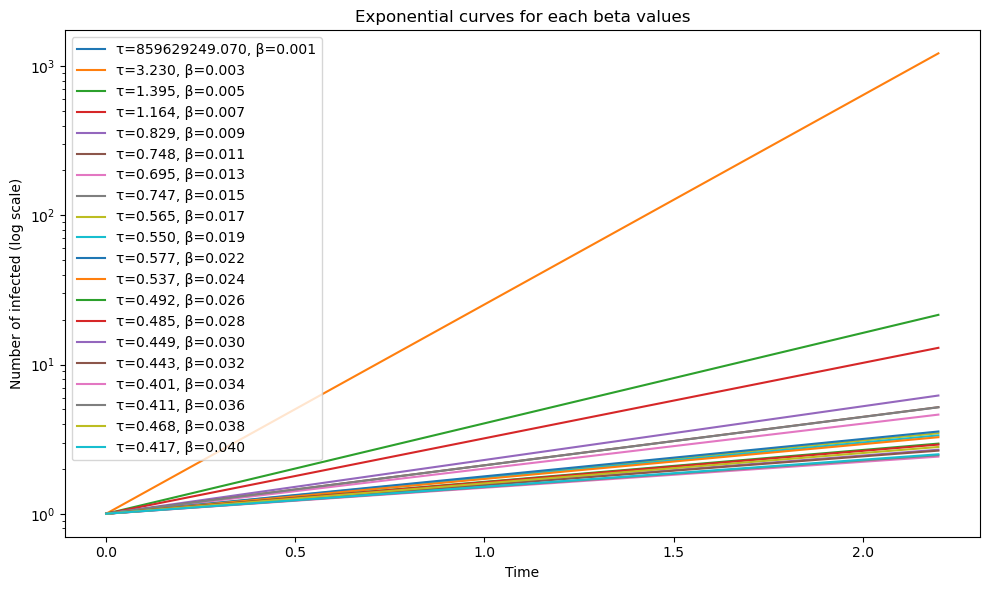

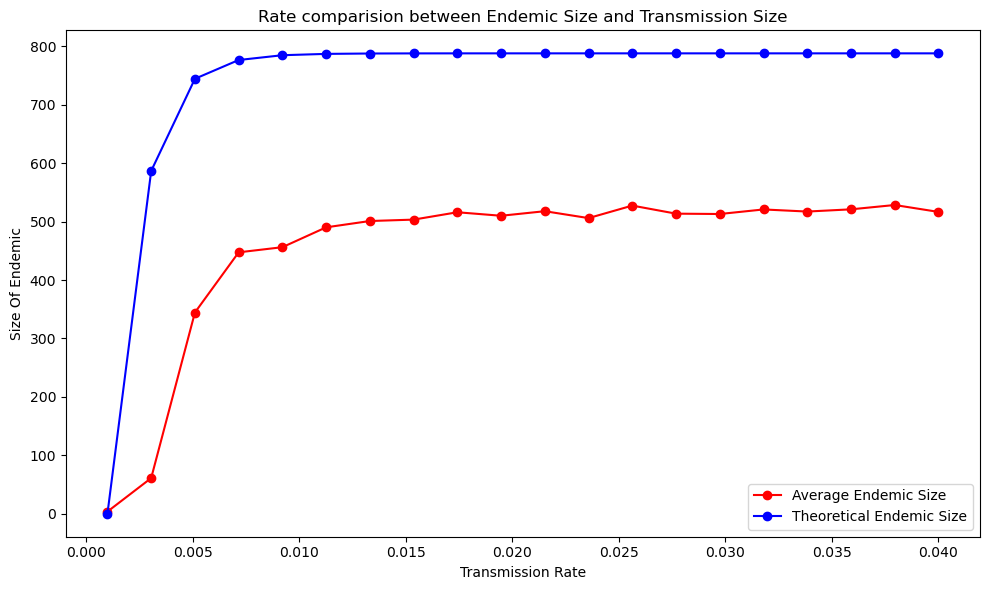

>>>>> Results for Part 2 <<<<<
Avg_taus = [8.60e+08 3.23e+00 1.40e+00 1.16e+00 8.29e-01 7.48e-01 6.95e-01 7.47e-01
 5.65e-01 5.50e-01 5.77e-01 5.37e-01 4.92e-01 4.85e-01 4.49e-01 4.43e-01
 4.01e-01 4.11e-01 4.68e-01 4.17e-01]

Avg endemic size = [  4.  61. 344. 447. 456. 490. 501. 503. 516. 510. 518. 506. 527. 514.
 513. 521. 517. 521. 528. 517.]

Theo endemic size = [  0. 587. 744. 777. 785. 787. 788. 788. 788. 788. 788. 788. 788. 788.
 788. 788. 788. 788. 788. 788.]

Min beta for random distribution = 0.00167
Min beta for arbitrary distribution = 0.00149


In [219]:
# do not modify
### 2.1
G = load_flu_network()

betas, beta_runs = simulate_beta_sweep(G, 5, beta_samples=20)

avg_taus = extract_average_tau(beta_runs)
times = np.linspace(0, 2.2, 100)

plot_beta_tau_curves(betas, avg_taus, t=times)

## 2.2
avg_endemic_sizes = extract_average_endemic_size(beta_runs)

(
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
) = calculate_theoretical_endemic(G, betas)

compare_endemic_sizes_vs_beta(
    betas,
    avg_endemic_sizes,
    theoretical_endemics_sizes,
    rand_dist_min_beta,
    arb_dist_min_beta,
)

# print results
print(">>>>> Results for Part 2 <<<<<")
with np.printoptions(precision=2, suppress=True):
    print(f"Avg_taus = {np.array(avg_taus)}\n")

with np.printoptions(precision=0, suppress=True):
    print(f"Avg endemic size = {np.array(avg_endemic_sizes)}\n")
    print(f"Theo endemic size = {np.array(theoretical_endemics_sizes)}\n")

print(f"Min beta for random distribution = {rand_dist_min_beta:.5f}")
print(f"Min beta for arbitrary distribution = {arb_dist_min_beta:.5f}")

### 2.3 Written Response

Answer: 

## Part 3
### 3.1 

In [ ]:
def sweep_initial_infected(G, tmax=10, beta=0.01, mu=0.5):
    """
    Compute the taus for each node.

    Inputs:
        G : nx.Graph
        tmax : int
        beta : float
        mu : float
    Returns:
        taus : list[float]
            List of tau's corresponding to the `nodes` return value below.
        nodes : list[int]
    """
    taus = []
    nodes = []

    return taus, nodes


# Compute centrality metrics
def compute_centrality(G, nodes):
    """
    Inputs:
        G : nx.Graph
        nodes : list[int]
             A list of nodes for which we compute centralities.
    Returns:
        cent_dict : dict[list[float]]
                  The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
                  The values are lists of floats representing the corresponding
                  centrality for each node in the `nodes` parameter.

    """
    deg_cen = []
    clo_cen = []
    bet_cen = []
    eig_cen = []


    cent_dict = {"deg": deg_cen, "clo": clo_cen, "bet": bet_cen, "eig": eig_cen}
    return cent_dict

### 3.2

In [ ]:
def calculate_person_correlation(taus, cent_dict):
    """
    Inputs:
        taus : list[float]
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`

    Returns:
        r_dict : dict[tuple[float, float]]
              The keys of the dict are 'deg', 'clo', 'bet' and 'eig'.
              The values are tuples of (Pearson coefficient, p-value).
    """
    r_deg = r_clo = r_bet = r_eig = (
        0.0,  # Pearson correlation coefficient
        0.0,  # p-value
    )

    r_dict = {"deg": r_deg, "clo": r_clo, "bet": r_bet, "eig": r_eig}
    return r_dict


def plot_centrality_vs_tau(taus, cent_dict, r_dict, save=False):
    """
    Inputs:
        taus : list[float]
            See docstring in `sweep_initial_infected`
        cent_dict : dict[list[float]]
                 See docstring in `compute_centrality`
        r_dict : dict[tuple[float, float]]
              See docstring in  `calculate_person_correlation`

        save: bool
    """

    # Plot centrality metrics v/s tau - 4 plots

    if save:
        plt.savefig("3_2.png")

    plt.show()

### 3.3

In [ ]:
# do not modify
start_time = time.time()
G = load_flu_network()

taus, nodes = sweep_initial_infected(G)
cent_dict = compute_centrality(G, nodes)

r_dict = calculate_person_correlation(taus, cent_dict)
plot_centrality_vs_tau(taus, cent_dict, r_dict)

print(f"Number of included nodes = {len(nodes)}")
for k in sorted(r_dict):
    coeff, pvalue = r_dict[k]
    print(f"{k} = {coeff:.4f}, pvalue = {pvalue:.4f}")

# We don't grade by how long it takes. This is purly informational.
seconds_elapsed = time.time() - start_time
print(f"Elapsed time = {seconds_elapsed/60 : .2f} minutes")

### 3.3 Written Response

Answer:

## Part 4: Knowledge Question [5 Points]

Answer:


(You can do this proof as markdown here or upload an image of the proof on paper. If you upload an image make sure to include the image file with your submission)